**How to use Center Crop**  
The following functions are in IsoDAT2D.py, and this tutorial includes a potential main to run the functions in.

In [1]:
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
import fabio
import SimDAT2D.SimDAT2D as sim

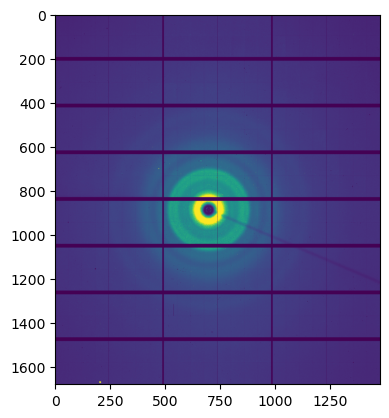

In [2]:
# Unprocessed image
file_path = 'da_7_c_gst_sio2.cbf'
# Open the .cbf file using fabio
image = fabio.open(file_path)
# Access the image data as a NumPy array
data = image.data
import matplotlib.pyplot as plt
plt.imshow(data, vmin=0, vmax=1000000)

In [3]:
def fill_with_circle(image, radius=None, center=None):
    """
    Fill NaN values with the mean of neighboring non-NaN pixels, but only within
    a circular region defined by radius and center
    Parameters:
    image: 2D numpy array
    radius: radius of circle (default: min(height,width)/2)
    center: (y,x) coordinates of circle center (default: image center)
    """
    # Create a copy of the image
    filled_image = np.copy(image)
    # Set defaults if not provided
    if center is None:
        center = (image.shape[0]//2, image.shape[1]//2)  # (y, x)
    if radius is None:
        radius = min(image.shape[0], image.shape[1])//2
    # Create a circular mask
    y, x = np.ogrid[:image.shape[0], :image.shape[1]]
    dist_from_center = np.sqrt((y - center[0])**2 + (x - center[1])**2)
    circle_mask = dist_from_center <= radius
    # Set all pixels outside circle to NaN
    filled_image[~circle_mask] = np.nan
    return filled_image

def fill_nan_with_neighbor_mean_circle(image, radius=None, center=None):
    """
    Fill NaN values with the mean of neighboring non-NaN pixels, but only within
    a circular region defined by radius and center
    Parameters:
    image: 2D numpy array
    radius: radius of circle (default: min(height,width)/2)
    center: (y,x) coordinates of circle center (default: image center)
    """
    # Create a copy of the image
    filled_image = np.copy(image)
    # Set defaults if not provided
    if center is None:
        center = (image.shape[0]//2, image.shape[1]//2)  # (y, x)
    if radius is None:
        radius = min(image.shape[0], image.shape[1])//2
    # Create a circular mask
    y, x = np.ogrid[:image.shape[0], :image.shape[1]]
    dist_from_center = np.sqrt((y - center[0])**2 + (x - center[1])**2)
    circle_mask = dist_from_center <= radius
    # Find NaN pixels
    nan_y, nan_x = np.where(np.isnan(filled_image))
    # Loop through each NaN pixel
    for y, x in zip(nan_y, nan_x):
        # Check if this pixel is within the circle
        if circle_mask[y, x]:
            # Define a window around the NaN pixel (5x5 window)
            y_start = max(0, y - 2)
            y_end = min(image.shape[0], y + 3)
            x_start = max(0, x - 2)
            x_end = min(image.shape[1], x + 3)
            # Extract the window
            window = filled_image[y_start:y_end, x_start:x_end]
            # Calculate mean of non-NaN values in the window
            mean_value = np.nanmean(window)
            # Replace NaN with the calculated mean
            filled_image[y, x] = mean_value
    # Set all pixels outside circle to NaN
    filled_image[~circle_mask] = np.nan
    return filled_image

In [4]:
def center_and_crop(image, crop_size=1400):
    """
    Displays an image, lets the user click 3 times to pick a center,
    then crops the image to a square region of `crop_size` x `crop_size`.
    """
    # Display image for clicks
    plt.figure("Select 3 Points", figsize=(14, 14))
    plt.imshow(image, vmin=0, vmax=1000000)
    plt.title("Click 3 times to select the center for cropping")
    plt.axis("on")
    
    # Capture exactly 3 clicks
    points = plt.ginput(3, timeout=-1)
    plt.close()
    
    if len(points) != 3:
        raise ValueError("You must click exactly 3 points.")
    
    # Compute the average click position
    center_x = int(np.mean([pt[0] for pt in points]))
    center_y = int(np.mean([pt[1] for pt in points]))
    print(f"Computed center: ({center_x}, {center_y})")
    
    # Calculate half-size
    half_size = crop_size // 2
    
    # Tentative boundaries
    x_min = center_x - half_size
    x_max = center_x + half_size
    y_min = center_y - half_size
    y_max = center_y + half_size
    
    # Ensure we don't go outside the image
    height, width = image.shape[:2]
    if x_min < 0:
        x_min = 0
        x_max = min(crop_size, width)
    if y_min < 0:
        y_min = 0
        y_max = min(crop_size, height)
    if x_max > width:
        x_max = width
        x_min = max(0, width - crop_size)
    if y_max > height:
        y_max = height
        y_min = max(0, height - crop_size)

    cropped_image = image[y_min:y_max, x_min:x_max]
    
    return cropped_image


In [5]:
def create_line_mask(image):
    """
    Creates a mask where True indicates valid pixel
    """
    mask = (image > 0)
    return mask

In [6]:
def preprocess_pilatus(file_name, crop_size=1400):
    """
    Loads a file, centers & crops (if needed), and creates a line mask.
    Returns (mask, corrected_image).
    """
    # Simple check to see if it's a CBF file
    if file_name.lower().endswith(".cbf"):
        print(f"Detected CBF file: {file_name}")
        image_data = fabio.open(file_name).data
        # Center & crop
        corrected_image = center_and_crop(image_data, crop_size=crop_size)
    else:
        print(f"Detected non-CBF file: {file_name}")
    
    # Create the mask to remove lines/gaps
    mask = create_line_mask(corrected_image)
    
    return mask, corrected_image


In [7]:
%matplotlib qt

**Change file name and any dimensions you want to alter depending on the size of your tiff or cbf file**

Detected CBF file: da_7_c_gst_sio2.cbf
Computed center: (698, 888)


C:\Users\chmer\AppData\Local\Temp\ipykernel_17200\3235887606.py:59: RuntimeWarning: Mean of empty slice
  mean_value = np.nanmean(window)


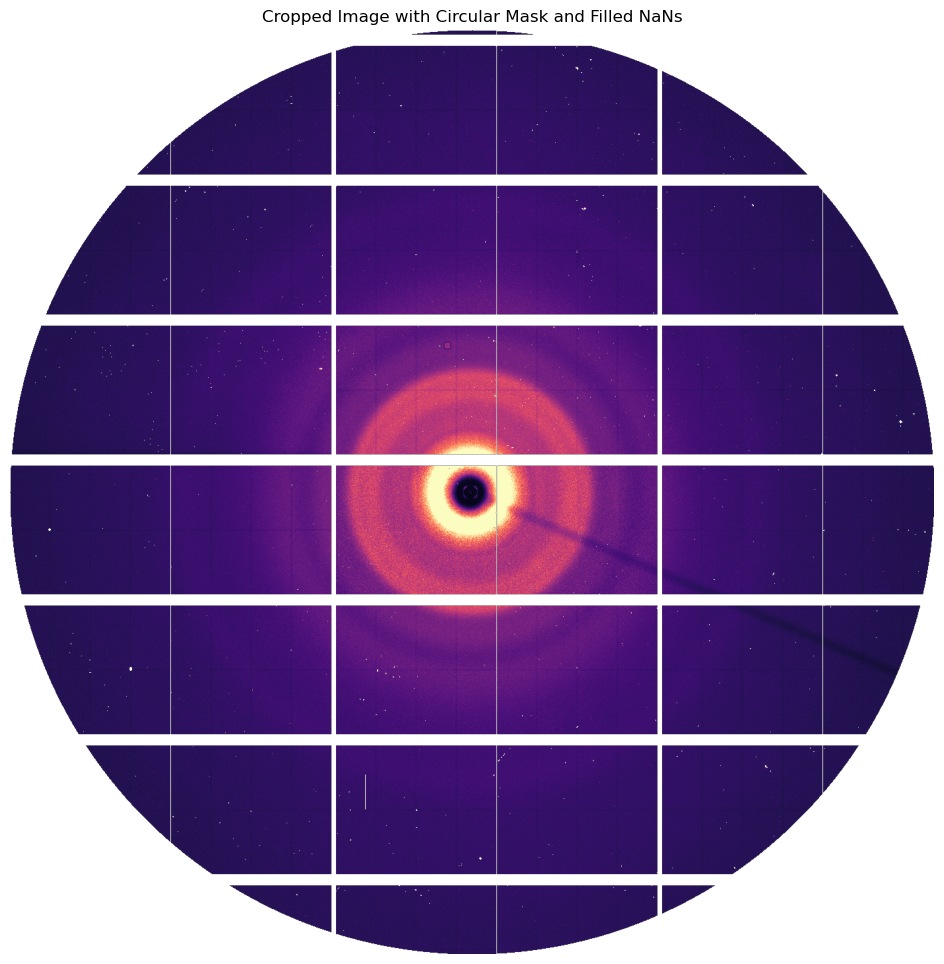

In [8]:

if __name__ == "__main__":

    file_name = "da_7_c_gst_sio2.cbf"  # Replace with your file path
    #Preprocess the image (center, crop, and create a line mask)
    mask, cropped_img = preprocess_pilatus(file_name, crop_size=1400)
    
    #Use the mask to set invalid pixels to NaN in the cropped image.
    processed_img = np.where(mask, cropped_img, np.nan)
    
    #Define the circular region parameters.
    circle_center = (processed_img.shape[0] // 2, processed_img.shape[1] // 2)
    circle_radius = 700
    circled_img = fill_with_circle(processed_img, radius=circle_radius, center=circle_center)
    
    #Fill in the NaN values within the circle using your second function.
    filled_img = fill_nan_with_neighbor_mean_circle(circled_img, radius=circle_radius, center=circle_center)
    
    # Display the final processed image
    %matplotlib inline
    plt.figure("Final Processed Image", figsize=(12, 12))
    plt.imshow(circled_img, cmap='magma', vmin=0, vmax=1000000)
    plt.title("Cropped Image with Circular Mask and Filled NaNs")
    plt.axis("off")
    plt.show()